## PLaStiCC

This is a pretty simple attempt at solving this problem. Metadata and simple statistics are used in a KNN to predict classes. The test data set is huge (19GB uncompressed) so parallel processing is used to accellerate prediction time. 

This doesn't perform very well on Kaggle, so theres a lot of room for improvement.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import multiprocessing as mp

from matplotlib import pyplot as plt

## Data loading and formatting:

In [3]:
def load_data(timeseries, metadata, validation=True):
    """Load data from files, process and combine into a single dataframe.
        Perform T-V split and return data ready for modelling.
        
        Params:
        timeseries: filename of a csv containing the PLaStiCC timeseries data
        metadata: filename of a csv containing the PLaStiCC metadata
        validation: break the dataset into train-test or just a full size training set."""
    
    start = time.time()
    
    # Load Data:    
    timeseries_df = pd.read_csv(timeseries)
    metadata_df = pd.read_csv(metadata)
    
    # Re-index data:
    metadata_df = metadata_df.set_index('object_id')
    metadata_df.index.type = 'int'
    
    # Construct feature dataframe:    
    print("Constructing Dataframe...")
    relevant_metadata = [feature for feature in list(metadata_df) if feature not in ["object_id"]]
    features = list(timeseries_df)
    features.remove('object_id')
    headers = []
    for feature in features:
        headers.extend([feature + '_mean', feature + '_stddev'])
    headers.extend(relevant_metadata)
    index = timeseries_df.object_id.unique()
    feature_df = pd.DataFrame(index=index, columns=headers)
    feature_df.rename_axis("object_id")
    feature_df.index.type = "int"
    
    # Populate feature dataframe with statistics by object
    print("Caclulating Statistics...")
    for object_id in timeseries_df.object_id.unique():
        subset = timeseries_df.query('object_id == {}'.format(str(object_id)))
        for feature in features:
            feature_df.loc[object_id][feature + '_mean'] = subset[feature].mean()
            feature_df.loc[object_id][feature + '_stddev'] = subset[feature].std()
        
    # Populate feature dataframe with metadata by object
    print("Joining Metadata...")
    for object_id in timeseries_df.object_id.unique():
        for feature in relevant_metadata:
            feature_df.loc[object_id][feature] = metadata_df.loc[object_id][feature]
            
    feature_df = feature_df.fillna(0.0)
    
    feature_df.target.type = 'string'
    X = feature_df.loc[:, feature_df.columns != 'target']
    y = feature_df.target
    y=y.astype('category')
    
    print("Finished loading data in %s Seconds" % str(time.time() - start))
    
    if validation:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        return X_train, X_test, y_train, y_test
    
    else:
        return X, y

## Load and Format Training Data

In [4]:
X_train, X_test, y_train, y_test = load_data("training_set.csv.zip", "training_set_metadata.csv", validation=True)

Constructing Dataframe...
Caclulating Statistics...
Joining Metadata...
Finished loading data in 145.0763852596283 Seconds


## Construct and Train Model 

In [5]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

### Get Prediction Accuracy on Validation Data:

In [6]:
predictions = clf.predict(X_test)

Accuracy = 100*(len([predictions[i] for i in range(len(predictions)) if predictions[i] == y_test[i]])/len(predictions))
print("Validation accuracy = %f percent" % Accuracy)

Validation accuracy = 42.866242 percent


## Bonus: See if we can enhance the model accuracy with a grid search.
(This is more applicable to more complex models, but whatever.)

The optimal value of K is 21, which gives a validation accuracy of 49.171975 Percent.


Text(0,0.5,'Validation Accuracy (%)')

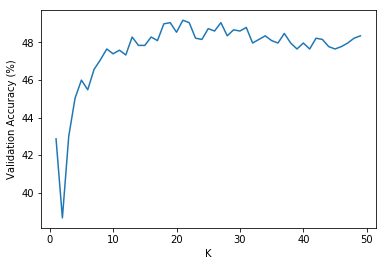

In [7]:
best_k = 1
best_accuracy = 0.0

accuracy_plot = []
test_points = range(1, 50, 1)

for k in test_points:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    Accuracy = 100*(len([predictions[i] for i in range(len(predictions)) if predictions[i] == y_test[i]])/len(predictions))
    accuracy_plot.append(Accuracy)
    if Accuracy > best_accuracy:
        best_k = k
        best_accuracy = Accuracy
        
print("The optimal value of K is %i, which gives a validation accuracy of %f Percent." % (best_k, best_accuracy))   

plt.plot(test_points, accuracy_plot)
plt.xlabel("K")
plt.ylabel("Validation Accuracy (%)")

## So, the model works..

Next we want to generate the full set of training data and re-train the model. Then, we'll make predictions on the test set. 

Note: The test set is _huge_ (6.8GB compressed .csv), so we'll need to process it incrementally. 

In [8]:
train_x, train_y = load_data("training_set.csv.zip", "training_set_metadata.csv", validation=False)

Constructing Dataframe...
Caclulating Statistics...
Joining Metadata...
Finished loading data in 138.21950483322144 Seconds


In [9]:
clf = KNeighborsClassifier(n_neighbors=best_k)
clf.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')

### Make predictions on the test data:
The test dataset is huge, so we're going to iterate through one-by-one and make a prediction on each object. This is probably gonna take a long time!

In [10]:
test_metadata_df = pd.read_csv("test_set_metadata.csv.zip")
test_metadata_df = test_metadata_df.set_index('object_id')
test_metadata_df.index.type = 'int'

In [11]:
len(test_objectids)

NameError: name 'test_objectids' is not defined

## Iterating through the 19GB csv file:

Here we define a function for processing a block of data, and then we iterate through the entire 19GB file and process each chunk. Multiprocessing is used to parallelize this process across all available cores (8 in this case).

In [12]:
def process_chunk(chunk_df, metadata_df):
    relevant_object_ids = chunk_df.object_id.unique()
    
    # Construct feature dataframe:    
    relevant_metadata = [feature for feature in list(metadata_df) if feature not in ["object_id"]]
    features = list(chunk_df)
    features.remove('object_id')
    headers = []
    for feature in features:
        headers.extend([feature + '_mean', feature + '_stddev'])
    headers.extend(relevant_metadata)
    index = chunk_df.object_id.unique()
    feature_df = pd.DataFrame(index=index, columns=headers)
    feature_df.rename_axis("object_id")
    feature_df.index.type = "int"
    
    # Populate feature dataframe with statistics by object
    for object_id in relevant_object_ids:
        subset = chunk_df.query('object_id == {}'.format(str(object_id)))
        for feature in features:
            feature_df.loc[object_id][feature + '_mean'] = subset[feature].mean()
            feature_df.loc[object_id][feature + '_stddev'] = subset[feature].std()
        
    # Populate feature dataframe with metadata by object
    for object_id in relevant_object_ids:
        for feature in relevant_metadata:
            feature_df.loc[object_id][feature] = metadata_df.loc[object_id][feature]
            
    feature_df = feature_df.fillna(0.0)
    X = feature_df.loc[:, feature_df.columns != 'target']
        
    return X

In [13]:
# This taks a really long time.

chunksize = 10 ** 6

chunks = pd.read_csv('test_set.csv.zip', chunksize=chunksize)
metadata_df = pd.read_csv('test_set_metadata.csv.zip')
metadata_df = metadata_df.set_index('object_id')
metadata_df.index.type = 'int'

def test_helper(chunk):
    X = process_chunk(chunk, metadata_df)
    Predictions = clf.predict(X)
    return [(X.index[i], Predictions[i]) for i in range(len(Predictions))]

# Updat this number to the number of cores in your CPU
pool = mp.Pool(8)

print('Starting Multiprocessing!')

# Execute the wait and print function in parallel
output = list(pool.imap_unordered(test_helper, chunks))

pool.close()
pool.join()

print('DONE')
    

Starting Multiprocessing!


Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-8:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py", line 1478, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-12-56c615fc3500>", line 19, in process_chunk
    subset = chunk_df.query('object_id == {}'.format(str(object_id)))
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py", line 1858, in _getitem_axis
    if is_iterator(key):
  File "<ipython-input-13-e85108c08156>", line 9, in test_helper
    X = process_chunk(chunk, metadata_df)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File 

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py", line 1478, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexes/range.py", line 485, in __len__
    return max(0, -(-(self._stop - self._start) // self._step))
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py", line 2789, in _take
    verify=True)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/internals.py", line 5048, in _interleaved_dtype
    dtype = find_common_type([b.dtype for b in blocks])
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py", line 1868, in _getitem_axis
    return self._getbool_axis(key, axis=axis)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py", lin

Now there's just a bunch of postprocessing to clean up the predictions and write them into a .csv as requested by the Kaggle competition.

In [73]:
import itertools 
flattened_results = list(chain.from_iterable(output))
flattened_results[:10]

[(13, 90.0),
 (14, 90.0),
 (17, 90.0),
 (23, 90.0),
 (34, 90.0),
 (35, 90.0),
 (43, 90.0),
 (50, 90.0),
 (60, 90.0),
 (69, 90.0)]

In [96]:
results_df = pd.DataFrame(flattened_results)
results_df = results_df.rename(index=str, columns={0: "object_id", 1: "class"})
results_df = results_df.set_index('object_id')
results_df['class'] = results_df['class'].astype('int')

In [66]:
results_df['class'].unique()
results_df.index.unique()

Int64Index([       13,        14,        17,        23,        34,        35,
                   43,        50,        60,        69,
            ...
            104663387, 104663589, 104663592, 104663631, 104663656, 104663659,
            104663682, 104663690, 104663735, 104663753],
           dtype='int64', name='object_id', length=3492890)

In [105]:
# Form the output file:
headers = ['class_6','class_15','class_16','class_42','class_52','class_53',
           'class_62','class_64','class_65','class_67','class_88','class_90','class_92','class_95','class_99']

results_df = pd.DataFrame(index=results_df.index.unique(), columns=headers)


In [106]:
results_df = results_df.fillna(0)

In [109]:
for item in flattened_results:
    results_df.loc[item[0]]['class_' + str(int(item[1]))] = 1

In [110]:
results_df.shape

(3492890, 15)

In [111]:
results_df.to_csv('submisson.csv')